# Random Forest Algorithm with Feedback for Arm-Use Detection

This notebook trains and tests random forest algorithm with output feedback for arm-use detection. The algorithm is trained on the data from the study by Dr Ann David [1].

[1] David, Ann, et al. "Quantification of the relative arm use in patients with hemiparesis using inertial measurement units." Journal of Rehabilitation and Assistive Technologies Engineering 8 (2021): 20556683211019694.

### Getting the data

If you do not already have the data to run this this notebook, 
you need to download it from here.  https://github.com/biorehab/upper-limb-use-assessment



### Standards modules

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy
from scipy import signal
import pathlib
import itertools
import glob
import json

In [3]:
import seaborn as sns

In [4]:
from matplotlib.ticker import MaxNLocator

### Custom Modules

In [5]:
sys.path.append("../scripts")

# import classification_algorithms as ca
# import reduced_models as rm
# import task_analysis as ta

import misc

In [6]:
# import gmac

In [7]:
# Define the font family and size
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.weight'] = 'light'  # Use 'light' font weight


## Define notebook level constants

In [8]:
# Sampling rate for the data is 50ms
dT = 0.02
Fs = int(1 / dT)
DATADIR = "../../gmac/data"
OUTDIR = "../output/"
OUTDIRDATA = OUTDIR + "data/"

## Read the Controls and Patients Data

In [9]:
# Read all healthy and patient data.
datadf = misc.read_summarize_data(datadir=DATADIR, dT=dT)

### Generate the autocorrelation function of the UL use data

In [10]:
N = 4000
all_ul_summary = misc.genrate_ul_autocorr_summary(datadf, N=4000)

unaff,  5,  3

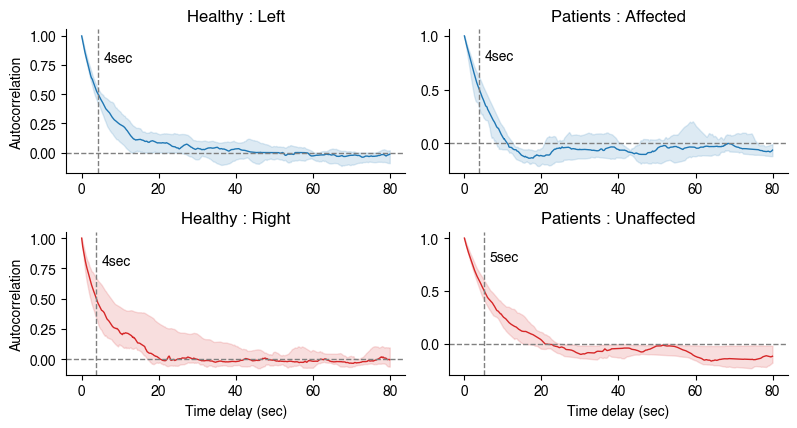

In [11]:
# Summary for healthy subjects
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(421)
_t = np.arange(N) * dT
q25 = np.percentile(all_ul_summary['left'], 25, axis=1)
q50 = np.percentile(all_ul_summary['left'], 50, axis=1)
q75 = np.percentile(all_ul_summary['left'], 75, axis=1)
_xlim = np.where(q50 >= 0.5)[0][-1]
ax.plot(_t, q50, lw=1, color="tab:blue")
ax.fill_between(x=_t, y1=q25, y2=q75, color='tab:blue', alpha=0.15)
ax.axvline(_t[_xlim], color="gray", ls="--", lw=1)
ax.axhline(0, color="gray", ls="--", lw=1)
ax.text(_t[_xlim] + 9, 0.75, f"{np.round(_t[_xlim]):.0f}sec", fontsize=10, ha="right", va="bottom")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel("Autocorrelation", fontsize=10)
ax.set_title("Healthy : Left", fontsize=12)

ax = fig.add_subplot(423)
q25 = np.percentile(all_ul_summary['right'], 25, axis=1)
q50 = np.percentile(all_ul_summary['right'], 50, axis=1)
q75 = np.percentile(all_ul_summary['right'], 75, axis=1)
_xlim = np.where(q50 >= 0.5)[0][-1]
ax.plot(_t, q50, lw=1, color="tab:red")
ax.fill_between(x=_t, y1=q25, y2=q75, color='tab:red', alpha=0.15)
ax.axvline(_t[_xlim], color="gray", ls="--", lw=1)
ax.axhline(0, color="gray", ls="--", lw=1)
ax.text(_t[_xlim] + 9, 0.75, f"{np.round(_t[_xlim]):.0f}sec", fontsize=10, ha="right", va="bottom")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel("Autocorrelation", fontsize=10)
ax.set_xlabel("Time delay (sec)", fontsize=10)
ax.set_title("Healthy : Right", fontsize=12)

ax = fig.add_subplot(422)
_t = np.arange(N) * dT
q25 = np.percentile(all_ul_summary['aff'], 25, axis=1)
q50 = np.percentile(all_ul_summary['aff'], 50, axis=1)
q75 = np.percentile(all_ul_summary['aff'], 75, axis=1)
_xlim = np.where(q50 >= 0.5)[0][-1]
ax.plot(_t, q50, lw=1, color="tab:blue")
ax.fill_between(x=_t, y1=q25, y2=q75, color='tab:blue', alpha=0.15)
ax.axvline(_t[_xlim], color="gray", ls="--", lw=1)
ax.axhline(0, color="gray", ls="--", lw=1)
ax.text(_t[_xlim] + 9, 0.75, f"{np.round(_t[_xlim]):.0f}sec", fontsize=10, ha="right", va="bottom")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title("Patients : Affected", fontsize=12)

ax = fig.add_subplot(424)
q25 = np.percentile(all_ul_summary['unaff'], 25, axis=1)
q50 = np.percentile(all_ul_summary['unaff'], 50, axis=1)
q75 = np.percentile(all_ul_summary['unaff'], 75, axis=1)
_xlim = np.where(q50 >= 0.5)[0][-1]
ax.plot(_t, q50, lw=1, color="tab:red")
ax.fill_between(x=_t, y1=q25, y2=q75, color='tab:red', alpha=0.15)
ax.axvline(_t[_xlim], color="gray", ls="--", lw=1)
ax.axhline(0, color="gray", ls="--", lw=1)
ax.text(_t[_xlim] + 9, 0.75, f"{np.round(_t[_xlim]):.0f}sec", fontsize=10, ha="right", va="bottom")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Time delay (sec)", fontsize=10)
ax.set_title("Patients : Unaffected", fontsize=12)
plt.tight_layout()

# Save figure
plt.savefig(f"{OUTDIR}/ul_autocorrelation_summary.svg", bbox_inches="tight")
plt.savefig(f"{OUTDIR}/ul_autocorrelation_summary.png", bbox_inches="tight", dpi=300)

The above figure indicates that the process has memory that last up to 10-20 seconds. Note that this might be due to the choice of tasks used in this dataset. It would this make sense to use a window of size 5 seonds or less, where the current output is moderate to strong correlation with the past output. 

### Supporting functions

In [10]:
def compute_confusion_matrix(actual: np.array, estimated: np.array) -> np.array:
    """
    Computes the components of the confusion matrix.
    """
    actual = np.array(actual, dtype=int)
    estimated = np.array(estimated, dtype=int)
    return {
        "TN": np.sum((actual + estimated) == 0), # TN
        "FP": np.sum((1 - actual + estimated) == 2), # FP
        "FN": np.sum((actual + 1 - estimated) == 2), # FN
        "TP": np.sum((actual + estimated) == 2), # TP
    }

## RF with output feedback

#### Parameter ranges for the grid search

In [20]:
# Input and output feedback window sizes
Tin = 1.0
Nin = int(Tin / dT)
Tout = (1.0, 2.5, 5.0)
Nout = tuple(map(lambda x: int(x / dT), Tout))

# Columns
raw_cols = ["subject", "segment", "ax", "ay", "az", "r1", "r2", "g1", "g2"]

# Compute the features for each segment for each subject.
data_features_df = misc.get_features_for_all(datadf, Nin, Nout, raw_cols)

[ 99 / 100] unaff  5  3

In [22]:
# Save the features data frame for the given Nin and Nout
for limb, df in data_features_df.items():
    df.to_csv(f"{OUTDIRDATA}/data_features_{limb}_{Nin}.csv", index=False)

Signature:
pd.DataFrame.join(
    self,
    other: 'DataFrame | Series | Iterable[DataFrame | Series]',
    on: 'IndexLabel | None' = None,
    how: 'MergeHow' = 'left',
    lsuffix: 'str' = '',
    rsuffix: 'str' = '',
    sort: 'bool' = False,
    validate: 'str | None' = None,
) -> 'DataFrame'
Docstring:
Join columns of another DataFrame.

Join columns with `other` DataFrame either on index or on a key
column. Efficiently join multiple DataFrame objects by index at once by
passing a list.

Parameters
----------
other : DataFrame, Series, or a list containing any combination of them
    Index should be similar to one of the columns in this one. If a
    Series is passed, its name attribute must be set, and that will be
    used as the column name in the resulting joined DataFrame.
on : str, list of str, or array-like, optional
    Column or index level name(s) in the caller to join on the index
    in `other`, otherwise joins index-on-index. If multiple
    values given, the `other` 

In [152]:
_df[raw_cols].join(_features, how="left").reset_index(drop=False)

,time,subject,segment,ax,ay,az,r1,r2,g1,g2,...,mean_z,var_x,var_y,var_z,mean_2,var_2,min_2,max_2,ent_2,outfb
0,2020-03-11 12:18:34.340,2,0,-0.704590,0.613770,0.076172,0,0,0,0,...,0.076172,0.000000,0.000000,0.000000,0.937530,0.000000,0.937530,0.937530,0.000000,0.0
1,2020-03-11 12:18:34.360,2,0,-0.726074,0.502930,0.105957,0,0,0,0,...,0.091064,0.000231,0.006143,0.000444,0.913554,0.001150,0.889578,0.937530,0.693147,0.0
2,2020-03-11 12:18:34.380,2,0,-0.777832,0.334473,0.094238,0,0,0,0,...,0.092122,0.001417,0.019778,0.000225,0.893011,0.001841,0.851925,0.937530,1.098557,0.0
3,2020-03-11 12:18:34.400,2,0,-0.673340,0.317871,0.085938,0,0,0,0,...,0.090576,0.001932,0.020062,0.000160,0.857144,0.006373,0.749542,0.937530,1.384910,0.0
4,2020-03-11 12:18:34.420,2,0,-0.707031,0.235840,0.021484,0,0,0,0,...,0.076758,0.001485,0.023569,0.001074,0.834842,0.007267,0.745637,0.937530,1.608651,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22754,2020-03-11 12:26:09.420,2,0,-0.068848,0.572266,-0.907715,0,0,0,0,...,-0.898535,0.000016,0.000024,0.000051,1.071562,0.000050,1.052050,1.083189,3.912023,0.0
22755,2020-03-11 12:26:09.440,2,0,-0.074707,0.571289,-0.896484,0,0,0,0,...,-0.898447,0.000016,0.000025,0.000051,1.071333,0.000050,1.052050,1.083189,3.912023,0.0
22756,2020-03-11 12:26:09.460,2,0,-0.069824,0.574219,-0.897949,0,0,0,0,...,-0.898311,0.000016,0.000025,0.000050,1.071119,0.000049,1.052050,1.083189,3.912023,0.0
22757,2020-03-11 12:26:09.480,2,0,-0.069824,0.578613,-0.888672,0,0,0,0,...,-0.898340,0.000017,0.000024,0.000050,1.071178,0.000048,1.052050,1.083189,3.912023,0.0


In [119]:
pd.DataFrame.join(_df[raw_cols], _features, on=_df.index)

ValueError: You are trying to merge on datetime64[ns] and int64 columns. If you wish to proceed you should use pd.concat

In [141]:
def compute_all_features(datadf: pd.DataFrame, Nin: int, Nout: int) -> pd.DataFrame:
    """Computes all the features using the given data frame.
    """
    # UL use
    _uludf = pd.DataFrame(1.0 * features.get_uluse_from_raters(datadf[["r1", "r2", "g1", "g2"]].values),
                          columns=["uluse"])
    # Accl. norm
    anormdf = pd.DataFrame(np.linalg.norm(datadf[["ax", "ay", "az"]].values, axis=1),
                           columns=["norm"])

    # Form the data frame
    return pd.DataFrame.from_dict({
        "time": datadf.index,
        "uluse": _uludf["uluse"].values,
        "mean_x": datadf["ax"].rolling(window=Nin, min_periods=1).mean().values,
        "mean_y": datadf["ay"].rolling(window=Nin, min_periods=1).mean().values,
        "mean_z": datadf["az"].rolling(window=Nin, min_periods=1).mean().values,
        "var_x": datadf["ax"].rolling(window=Nin, min_periods=1).var().fillna(0).values,
        "var_y": datadf["ay"].rolling(window=Nin, min_periods=1).var().fillna(0).values,
        "var_z": datadf["az"].rolling(window=Nin, min_periods=1).var().fillna(0).values,
        "mean_2": anormdf["norm"].rolling(window=Nin, min_periods=1).mean().values,
        "var_2": anormdf["norm"].rolling(window=Nin, min_periods=1).var().fillna(0).values,
        "min_2": anormdf["norm"].rolling(window=Nin, min_periods=1).min().values,
        "max_2": anormdf["norm"].rolling(window=Nin, min_periods=1).max().values,
        "ent_2": anormdf["norm"].rolling(window=Nin, min_periods=1).apply(misc.entropy).values,
        "outfb": _uludf["uluse"].rolling(window=Nout, min_periods=1).mean().values
    }).set_index("time")

In [139]:
_feat = compute_all_features(_df, Nin, Nout)

DatetimeIndex(['2020-03-11 12:18:34.340000', '2020-03-11 12:18:34.360000',
               '2020-03-11 12:18:34.380000', '2020-03-11 12:18:34.400000',
               '2020-03-11 12:18:34.420000', '2020-03-11 12:18:34.440000',
               '2020-03-11 12:18:34.460000', '2020-03-11 12:18:34.480000',
               '2020-03-11 12:18:34.500000', '2020-03-11 12:18:34.520000',
               ...
               '2020-03-11 12:26:09.320000', '2020-03-11 12:26:09.340000',
               '2020-03-11 12:26:09.360000', '2020-03-11 12:26:09.380000',
               '2020-03-11 12:26:09.400000', '2020-03-11 12:26:09.420000',
               '2020-03-11 12:26:09.440000', '2020-03-11 12:26:09.460000',
               '2020-03-11 12:26:09.480000', '2020-03-11 12:26:09.500000'],
              dtype='datetime64[ns]', name='time', length=22759, freq=None)


In [140]:
_feat

,uluse,mean_x,mean_y,mean_z,var_x,var_y,var_z,mean_2,var_2,min_2,max_2,ent_2,outfb
time,,,,,,,,,,,,,
2020-03-11 12:18:34.340,0.0,-0.704590,0.613770,0.076172,0.000000,0.000000,0.000000,0.937530,0.000000,0.937530,0.937530,0.000000,0.0
2020-03-11 12:18:34.360,0.0,-0.715332,0.558350,0.091064,0.000231,0.006143,0.000444,0.913554,0.001150,0.889578,0.937530,0.693147,0.0
2020-03-11 12:18:34.380,0.0,-0.736165,0.483724,0.092122,0.001417,0.019778,0.000225,0.893011,0.001841,0.851925,0.937530,1.098557,0.0
2020-03-11 12:18:34.400,0.0,-0.720459,0.442261,0.090576,0.001932,0.020062,0.000160,0.857144,0.006373,0.749542,0.937530,1.384910,0.0
2020-03-11 12:18:34.420,0.0,-0.717773,0.400977,0.076758,0.001485,0.023569,0.001074,0.834842,0.007267,0.745637,0.937530,1.608651,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-11 12:26:09.420,0.0,-0.073330,0.579189,-0.898535,0.000016,0.000024,0.000051,1.071562,0.000050,1.052050,1.083189,3.912023,0.0
2020-03-11 12:26:09.440,0.0,-0.073379,0.578896,-0.898447,0.000016,0.000025,0.000051,1.071333,0.000050,1.052050,1.083189,3.912023,0.0
2020-03-11 12:26:09.460,0.0,-0.073232,0.578730,-0.898311,0.000016,0.000025,0.000050,1.071119,0.000049,1.052050,1.083189,3.912023,0.0


(0.0, 1000.0)

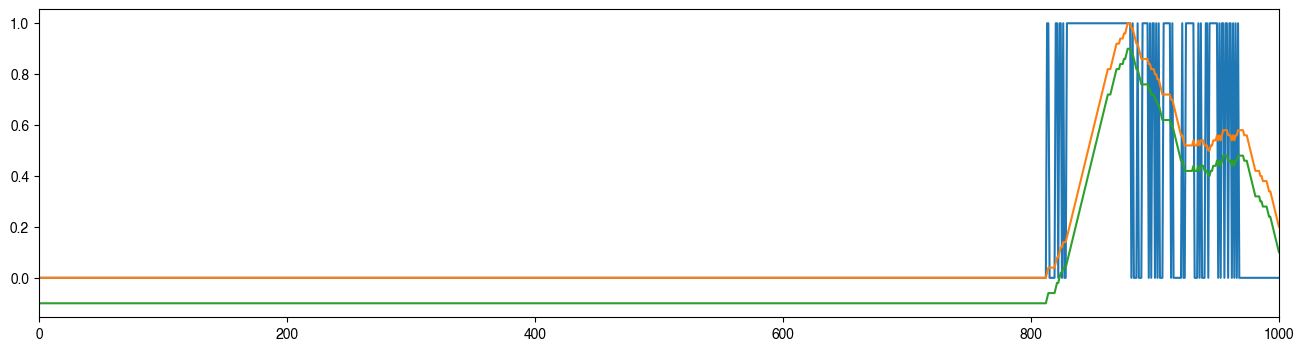

In [112]:
_outfb = _feat['uluse'].rolling(window=Nin, min_periods=1).mean().values

plt.figure(figsize=(16, 4))
plt.plot(_feat["uluse"])
plt.plot(_outfb)
plt.plot(_feat["outfb"] - 0.1)
plt.xlim(0, 1000)

In [114]:
np.sum(np.abs(_outfb - _feat["outfb"].values))

0.0

In [89]:
anorm = pd.DataFrame(np.linalg.norm(_df[["ax", "ay", "az"]].values, axis=1),
                     columns=["norm"])
_ent = anorm["norm"].rolling(window=Nin, min_periods=1).apply(misc.entropy).values

In [90]:
misc.entropy(anorm.loc[1:50, 'norm'].values), _ent[50]

(3.8545979869279003, 3.8545979869279003)

In [87]:
anorm["norm"].rolling(window=Nin, min_periods=1)

Rolling [window=50,min_periods=1,center=False,axis=0,method=single]

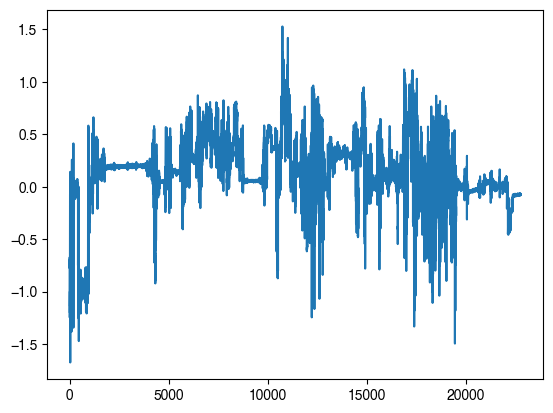

In [58]:
plt.plot(_df[["ax"]].values)

In [55]:
_df[["r1", "r2", "g1", "g2"]].values

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       ...,
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

array([0.54989048, 0.29256937, 0.53610096, 0.05531643, 0.91847957,
       0.25907769, 0.60555406, 0.08188931, 0.63493748, 0.96751274,
       0.97245817, 0.30661488, 0.76463435, 0.92972164, 0.75409309,
       0.85609548, 0.23373942, 0.33261119, 0.32542682, 0.96762257,
       0.01104436, 0.35961341, 0.14315529, 0.62376046, 0.2714935 ,
       0.37767455, 0.8812042 , 0.53680885, 0.10965191, 0.00151575,
       0.91297476, 0.04441698, 0.45588772, 0.82481701, 0.78171543,
       0.84446482, 0.04582705, 0.31353859, 0.2734429 , 0.4418449 ,
       0.34039022, 0.60792913, 0.72466465, 0.84899786, 0.18240721,
       0.41946915, 0.93759098, 0.05877083, 0.14274975, 0.27782366,
       0.73490633, 0.98695514, 0.83292028, 0.76448052, 0.27390139,
       0.047684  , 0.47487243, 0.65632353, 0.93074257, 0.95681735,
       0.467634  , 0.5133064 , 0.59934933, 0.49764071, 0.47721811,
       0.92941465, 0.85725209, 0.83309457, 0.42856503, 0.72033255,
       0.18286791, 0.07236244, 0.50505632, 0.20130787, 0.55457

In [31]:
pd.concat((data_features_df[limb],
           _df[raw_cols].reset_index(drop=True)),
          axis=0,
          ignore_index=True)

,subject,segment,ax,ay,az,r1,r2,g1,g2,uluse,...,min_x2,min_y2,min_z2,max_x2,max_y2,max_z2,ent_x,ent_y,ent_z,outfb
0,2,0,-0.704590,0.613770,0.076172,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0,-0.726074,0.502930,0.105957,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,-0.777832,0.334473,0.094238,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,0,-0.673340,0.317871,0.085938,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,0,-0.707031,0.235840,0.021484,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22754,2,0,-0.068848,0.572266,-0.907715,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22755,2,0,-0.074707,0.571289,-0.896484,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22756,2,0,-0.069824,0.574219,-0.897949,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22757,2,0,-0.069824,0.578613,-0.888672,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
_df

,ax,ay,az,gx,gy,gz,pitch,yaw,mx,my,...,subject,old_time,r1,r2,g1,g2,task,use_type,gnd,segment
time,,,,,,,,,,,,,,,,,,,,,
2020-03-11 12:18:34.340,-0.704590,0.613770,0.076172,-1.062537,0.340931,-0.282356,-10.199455,420.072372,-0.601504,52.180451,...,2,2020-03-11 12:18:33.620,0,0,0,0,,,0,0
2020-03-11 12:18:34.360,-0.726074,0.502930,0.105957,-0.744334,0.256857,-0.363769,-11.286190,422.220091,1.503759,53.383459,...,2,2020-03-11 12:18:33.640,0,0,0,0,,,0,0
2020-03-11 12:18:34.380,-0.777832,0.334473,0.094238,-0.488919,0.146178,-0.474980,-12.418367,421.396061,1.203008,52.631579,...,2,2020-03-11 12:18:33.660,0,0,0,0,,,0,0
2020-03-11 12:18:34.400,-0.673340,0.317871,0.085938,-0.636315,0.138728,-0.707514,-13.778245,420.937020,0.751880,50.526316,...,2,2020-03-11 12:18:33.680,0,0,0,0,,,0,0
2020-03-11 12:18:34.420,-0.707031,0.235840,0.021484,-0.703893,0.138728,-0.821918,-15.278585,421.524763,1.654135,52.781955,...,2,2020-03-11 12:18:33.700,0,0,0,0,,,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-11 12:26:09.420,-0.068848,0.572266,-0.907715,-0.001504,-0.000153,-0.000868,-3.747362,577.536703,20.000000,66.165414,...,2,2020-03-11 12:26:08.700,0,0,0,0,,,0,0
2020-03-11 12:26:09.440,-0.074707,0.571289,-0.896484,-0.002568,-0.000153,0.000728,-4.279340,577.536991,20.300752,65.864662,...,2,2020-03-11 12:26:08.720,0,0,0,0,,,0,0
2020-03-11 12:26:09.460,-0.069824,0.574219,-0.897949,-0.003633,-0.001750,-0.000336,-3.779946,577.539522,20.150376,65.263158,...,2,2020-03-11 12:26:08.740,0,0,0,0,,,0,0


In [19]:
data = _df['ax'].values.reshape(-1, 1)
# estimate pdf using KDE with gaussian kernel
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(data)
log_p = kde.score_samples(data)
stats.entropy(np.exp(log_p))

9.943073491339

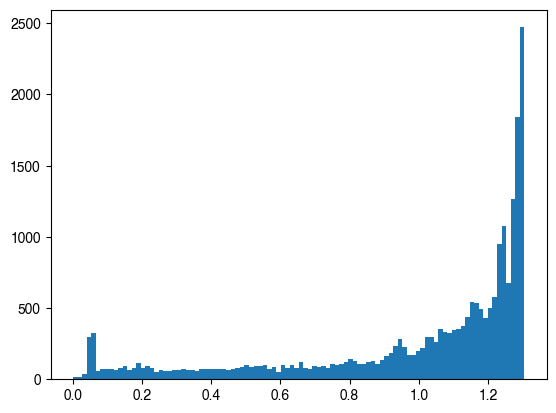

In [26]:
plt.hist(np.exp(log_p), bins=100);

In [11]:
basedir = "../data/output-r1-full-new"

# Make directory if it does not exist
outdir = pathlib.Path(basedir, "gmac")
outdir.mkdir(parents=True, exist_ok=True)

# GMAC Parameter ranges
gmac_param_ranges = {
    "np": list(map(int, [1, Fs // 2, Fs])),
    "fc": [0.01, 0.1],
    "nc": [1, 2],
    "nam": list(map(int, [1, Fs // 2, Fs])),
    "p_th": list(range(-90, 100, 10)),
    "p_th_band": list(range(0, 100, 20)),
    "am_th": [0, 0.1, 0.25],
    "am_th_band": [0]
}

# Save params file.
with open(pathlib.Path(outdir, "gmac_params.json"), "w") as f:
    json.dump(gmac_param_ranges, f, indent=4)

In [12]:
dfcols = (["subject"] + list(gmac_param_ranges.keys()) +
            ["limb"] +
            ["TN", "FP", "FN", "TP"] +
            ["TNr", "FPr", "FNr", "TPr"] +
            ["sensitivity", "specificity", "youden"])
gmac_perf_df = pd.DataFrame(columns=dfcols)
for limbkey in ["left", "right", "aff", "unaff"]:
    # Which limb?
    limbdf = datadf[limbkey]
    subjects = limbdf.subject.unique()

    # Estimate pitch for each subject.
    accl_cols = ['ax', 'ay', 'az']

    # Number of all possible combinations
    Ncombs = len(list(misc.generate_param_combinations_gmac(gmac_param_ranges)))

    # All parameter combinations.
    param_combs = list(misc.generate_param_combinations_gmac(gmac_param_ranges))

    for i, subj in enumerate(subjects):
        # Go through all parameter combinations.
        _sinx = limbdf.subject == subj
        for j, _pc in enumerate(param_combs):
            sys.stdout.write(f"\r{limbkey} {i:3d}, {j:3d} / {len(param_combs):3d}")
            df = limbdf[limbdf.subject==subj]
            # Compute gmac
            _gmac = np.hstack([
                gmac.estimate_gmac2(_df[accl_cols].values, accl_farm_inx=0, Fs=Fs,
                                    params=_pc)
                for _, _df in df.groupby('segment')
            ])
            # Compute performance
            _perf = compute_confusion_matrix(actual=df.gnd.values, estimated=_gmac)
            
            # Update gmac df
            _rowdf = pd.DataFrame({"subject": subj} | _pc | _perf, index=[0])
            _rowdf[["TNr", "FPr", "FNr", "TPr"]] = _rowdf[["TN", "FP", "FN", "TP"]] / np.sum(_rowdf[["TN", "FP", "FN", "TP"]].values)
            _rowdf["sensitivity"] = _rowdf.TP / (_rowdf.TP + _rowdf.FN)
            _rowdf["specificity"] = _rowdf.TN / (_rowdf.TN + _rowdf.FP)
            _rowdf["youden"] = _rowdf.sensitivity + _rowdf.specificity - 1
            _rowdf["limb"] = limbkey
            gmac_perf_df = pd.concat(
                (gmac_perf_df, _rowdf),
                ignore_index=True
            )
    # Save data
    gmac_perf_df.to_csv(pathlib.Path(basedir, "gmac", f"perf_gmac.csv").as_posix(), index=False)

unaff   4, 15389 / 15390